In [38]:
import abjad
# NOTE: Sharp is coded as <note_name>s
# NOTE: Flat  is coded as <note_name>f
string = "c'16 f' g' a' d' g' a' b' e' a' b' c'' f' b' c'' d''16"
voice_1 = abjad.Voice(string, name="Voice_1")
staff_1 = abjad.Staff([voice_1], name="Staff_1")
abjad.show(staff_1)

In [3]:
COLOR.WHITE.value

(255, 255, 255)

In [66]:
import cv2
import numpy as np
from PIL import Image

from typing import Tuple, List
from src.video import skip_intro
from src.video import go_to_next
from src.image import quantize_palette
from src.image import COLOR

video_path = 'video/exile - Taylor Swift & Bon Iver  Piano Tutorial.mp4'

capture = cv2.VideoCapture(video_path)
fps = capture.get(cv2.CAP_PROP_FPS)

data = skip_intro(capture)

palette = [COLOR.WHITE, COLOR.BLACK, COLOR.RED, COLOR.GREEN]

music = [data := go_to_next(capture, data[0], thr=5e-4) for i in range(100)]
frames = [frame for frame, _ in music]
frames = [quantize_palette(frame, palette=palette) for frame in frames]

# NOTE: Because our functions measures the SKIPPED number of frames, to actually
#       measure the duration of each frame we need to referred to the next frame
#       skipped frames to know how long the previous frame lasted, with the last
#       detected frame having an unknown duration because we haven't detected its
#       end yet! Moreover, we discard how many skipped frame there were for the
#       intro as that's of no use to us. We mark unknown duration with [0].
times  = [time  for _, time  in music[1:]] + [0]

In [146]:
import importlib
import src.keyboard
import src.image
importlib.reload(src.image)
importlib.reload(src.keyboard)
from itertools import pairwise
from src.image import bbox_notes
from src.keyboard import find_notes
from src.keyboard import get_keyboard_layout
from src.keyboard import get_keyboard_spacings

music = {
    'left-hand' : [],
    'right-hand': [],
}

color_hand_map = {
    # ! FIXME: It puzzles me why we need to put .value here but somehow
    # !        we get a KeyError if we don't.
    COLOR.RED.value   : 'left-hand',
    COLOR.GREEN.value : 'right-hand'
}

layout = get_keyboard_layout(
    separate_bw=True,
    num_octaves=7,
    start_octave=1,
    start_note='D',
    end_note='G',
    black_key_notation='sharp',
    trim_black_borders=False,
    clean_fake_black_keys=True,
)

spacings = get_keyboard_spacings(
    num_octaves=7,
    start_note='D',
    end_note='G',
)

for frame in frames:
    notes = find_notes(
        bbox_notes(
            frame,
            noise_cutoff=(0.2, 0.8),
            cutoff_value=(0, 0),
            color_use_enum=True,
        ),
        key_layout = layout,
        key_spacings = spacings,
        color_hand_map = color_hand_map,
    )

    music['left-hand' ].append(notes['left-hand'])
    music['right-hand'].append(notes['right-hand'])

In [147]:
def clean_music(
    music,
    times,
):
    flags = []

    for time, (pred, succ) in zip(times[1:], pairwise(range(len(times)))):
        for name in music:
            if time == 1 and any([n not in music[name][pred] for n in music[name][succ]]):
                flags.append(succ)

    flags = set(flags)
    for name in music:
        music[name] = [v for idx, v in enumerate(music[name]) if idx not in flags]

    times = [t for idx, t in enumerate(times) if idx not in flags]

    return music, times

music, times = clean_music(music, times)

In [150]:
times[:20]

[24, 1, 11, 6, 6, 2, 10, 13, 5, 18, 24, 2, 10, 7, 6, 1, 11, 12, 5, 12]

In [134]:
music['left-hand'][:10]

[['C#-3', 'F#-2'],
 ['F#-2'],
 ['C#-3', 'F#-2'],
 ['C#-3', 'F#-2'],
 ['C#-3', 'F#-2'],
 ['F#-2'],
 ['C#-3', 'F#-2'],
 ['C#-3', 'F#-2'],
 ['F#-2'],
 ['C#-3', 'F#-2']]

In [133]:
music['right-hand'][:10]

[[],
 [],
 [],
 ['F#-3'],
 ['C#-4'],
 ['C#-4'],
 ['C#-4'],
 ['A#-3'],
 ['G#-3'],
 ['G#-3']]

In [148]:
import importlib
import src.timings
importlib.reload(src.timings)
from src.timings import attach_times
from src.timings import get_partition

timed = attach_times(music, times, fps=fps, min_t_frame=0.1)
# print(timed['right-hand'])
# print(timed['left-hand'])
part = get_partition(timed, quarter_bpm=74, minimum_unit=16)
# print(part['right-hand'])
part

{'left-hand': defaultdict(list,
             {0: [{'C#-3': 4, 'F#-2': 16, 'T_FRAME': 4, 'T_ELAPSED': 0},
               {'C#-3': 4, 'T_FRAME': 4, 'T_ELAPSED': 4},
               {'C#-3': 8, 'T_FRAME': 8, 'T_ELAPSED': 8}],
              1: [{'A#-2': 4, 'D#-2': 16, 'T_FRAME': 4, 'T_ELAPSED': 16},
               {'A#-2': 4, 'T_FRAME': 4, 'T_ELAPSED': 20},
               {'A#-2': 8, 'T_FRAME': 8, 'T_ELAPSED': 24}],
              2: [{'C#-3': 4, 'F#-2': 16, 'T_FRAME': 4, 'T_ELAPSED': 32},
               {'C#-3': 4, 'T_FRAME': 4, 'T_ELAPSED': 36},
               {'C#-3': 4, 'T_FRAME': 4, 'T_ELAPSED': 40},
               {'C#-3': 4, 'T_FRAME': 4, 'T_ELAPSED': 44}],
              3: [{'A#-2': 4, 'D#-2': 16, 'T_FRAME': 4, 'T_ELAPSED': 48},
               {'A#-2': 4, 'T_FRAME': 4, 'T_ELAPSED': 52},
               {'A#-2': 4, 'T_FRAME': 4, 'T_ELAPSED': 56},
               {'A#-2': 4, 'T_FRAME': 4, 'T_ELAPSED': 60}],
              4: [{'F#-3': 4,
                'C#-3': 4,
                'F#-2': 

In [149]:
import importlib
import src.sheet
import src.misc
importlib.reload(src.misc)
importlib.reload(src.sheet)
import abjad
from src.sheet import get_score

score = get_score(
    partition=part,
    key='gf',
    clef={
        'left-hand' : 'bass',
        'right-hand' : {
            0 : 'bass',
            4 : 'treble',
        }
    }
)

abjad.show(score)

AssignabilityError: not assignable duration: Duration(5, 16).

In [79]:
from collections import defaultdict
tmp = {'A#-4': 1,
        'C#-4': 1,
        'A#-3': 1,
        'T_FRAME': 1,
        'T_ELAPSED': 98}
inv = defaultdict(list)

for k, v in tmp.items():
    if 'T_' in k: continue
    inv[v].append(k)

print(inv)

defaultdict(<class 'list'>, {1: ['A#-4', 'C#-4', 'A#-3']})


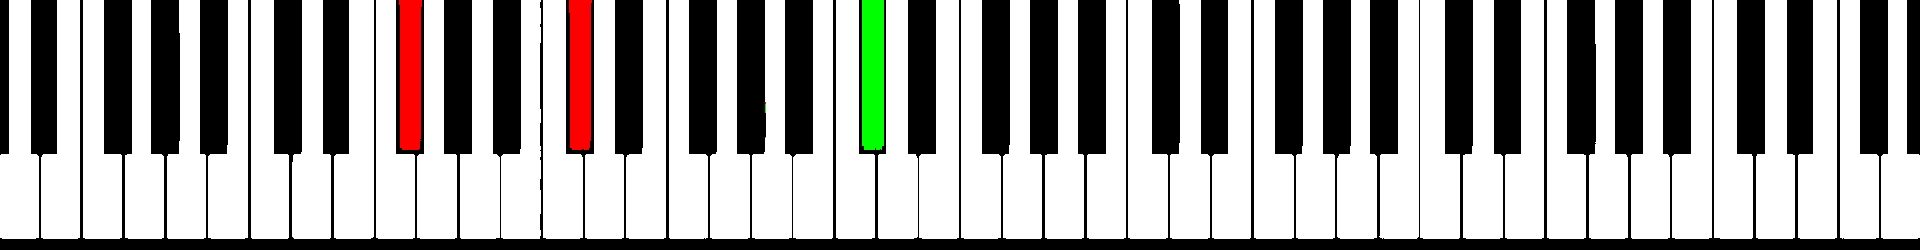

In [29]:
import importlib
import src.keyboard
import src.image
importlib.reload(src.image)
from src.image import frame_threshold
from src.image import frame_to_pil
from src.image import erase_by_color
from src.image import quantize_palette

# tmp = quantize_palette(frames[2], palette=palette)
frame_to_pil(frames[5])

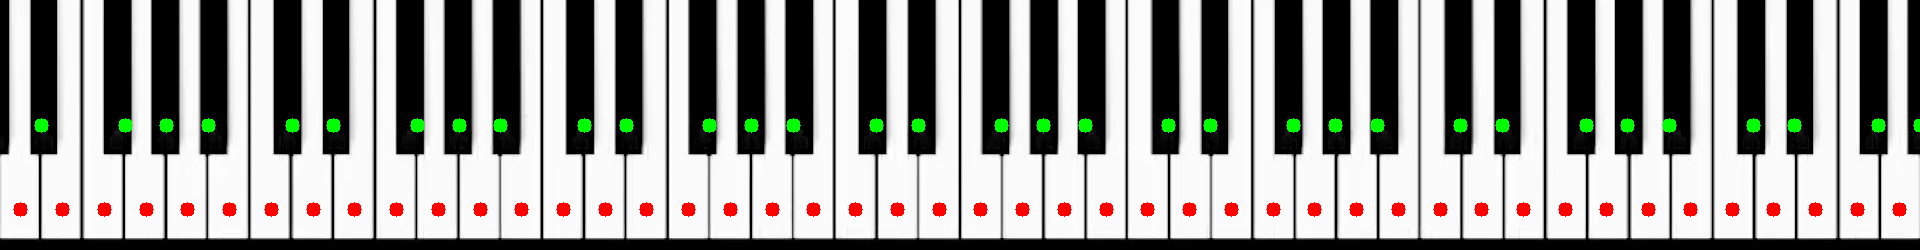

In [404]:
# seq = np.vstack(frames)
tmp = frames[0].copy()
tmp = np.repeat(tmp[..., None], 3, axis=2)
h, w, c = tmp.shape

for x in w_sp:
    cv2.circle(tmp, (int(x * w), h - h // 6), 2, (255, 0, 0), 10)

for x in b_sp:
    cv2.circle(tmp, (int(x * w), h // 2), 2, (0, 255, 0), 10)

frame_to_pil(tmp)

In [111]:
import abjad
# NOTE: Sharp is coded as <note_name>s
# NOTE: Flat  is coded as <note_name>f


# duration = abjad.Duration(1, 4)
# notes = [abjad.Note(pitch, duration) for pitch in range(8)]
# staff = abjad.Staff(notes)

staff = abjad.Staff([], name="Left-Hand")

for notes in music['left-hand']:
    voices = []
    if len(notes):
        for note in notes:
            name, octave = note.split('-')
            
            name = name.lower().replace('#', 's').replace('b', 'f')
            pitch = "'" * (int(octave) - 3) + ',' * (3 - int(octave))
            
            duration = abjad.Duration(1, 8)
            note = abjad.Note(name + pitch, duration)

            voice = abjad.Voice([note])
            voices.append(voice)
    else:
        voice = abjad.Voice('r ')
        voices = [voice]

    print(voices)
    tmp = abjad.Staff(voices, name="Left-Hand", simultaneous=True)

    staff.append(tmp)

key_signature = abjad.KeySignature(
    abjad.NamedPitchClass("fs"), abjad.Mode("major")
)

clef = abjad.Clef(name='bass')
abjad.attach(key_signature, staff[0][0][0])
abjad.attach(clef, staff[0][0][0])

print(music['left-hand'])
score = abjad.Score([staff], name="Example_Score")

# abjad.persist(score).as_png(preview=True)

abjad.show(score)

[Voice('r4')]
[Voice('cs8'), Voice('fs,8')]
[Voice('fs,8')]
[Voice('cs8'), Voice('fs,8')]
[Voice('cs8'), Voice('fs,8')]
[Voice('cs8'), Voice('fs,8')]
[Voice('fs,8')]
[Voice('cs8'), Voice('fs,8')]
[Voice('cs8'), Voice('fs,8')]
[Voice('fs,8')]
[Voice('cs8'), Voice('fs,8')]
[[], ['C#-3', 'F#-2'], ['F#-2'], ['C#-3', 'F#-2'], ['C#-3', 'F#-2'], ['C#-3', 'F#-2'], ['F#-2'], ['C#-3', 'F#-2'], ['C#-3', 'F#-2'], ['F#-2'], ['C#-3', 'F#-2']]


[['C#-3', 'F#-2'], ['F#-2'], ['C#-3', 'F#-2'], ['C#-3', 'F#-2'], ['C#-3', 'F#-2'], ['F#-2'], ['C#-3', 'F#-2'], ['C#-3', 'F#-2'], ['F#-2'], ['C#-3', 'F#-2'], ['C#-3', 'F#-2'], ['A#-2', 'D#-2'], ['D#-2'], ['A#-2', 'D#-2'], ['A#-2', 'D#-2'], ['A#-2', 'D#-2'], ['D#-2'], ['A#-2', 'D#-2'], ['A#-2', 'D#-2'], ['D#-2'], ['A#-2', 'D#-2'], ['A#-2', 'D#-2'], ['A#-2', 'D#-2'], ['C#-3', 'F#-2'], ['F#-2'], ['C#-3', 'F#-2'], ['C#-3', 'F#-2'], ['C#-3', 'F#-2'], ['F#-2'], ['C#-3', 'F#-2'], ['C#-3', 'F#-2'], ['F#-2'], ['C#-3', 'F#-2'], ['C#-3', 'F#-2'], ['A#-2', 'D#-2'], ['D#-2'], ['A#-2', 'D#-2'], ['A#-2', 'D#-2'], ['A#-2', 'D#-2'], ['D#-2'], ['A#-2', 'D#-2'], ['A#-2', 'D#-2'], ['D#-2'], ['A#-2', 'D#-2'], ['A#-2', 'D#-2'], ['A#-2', 'D#-2'], ['F#-3', 'C#-3', 'F#-2'], ['F#-3', 'C#-3', 'F#-2'], ['F#-3', 'C#-3', 'F#-2'], ['F#-3', 'C#-3', 'F#-2'], [], ['C#-3'], ['C#-3'], ['C#-3'], ['C#-3'], ['C#-3'], [], ['C#-3'], ['C#-3'], ['F#-3'], ['F#-3', 'C#-3'], ['F#-3', 'C#-3'], ['D#-3', 'A#-2', 'D#-2'], ['D#-3', 'A#-

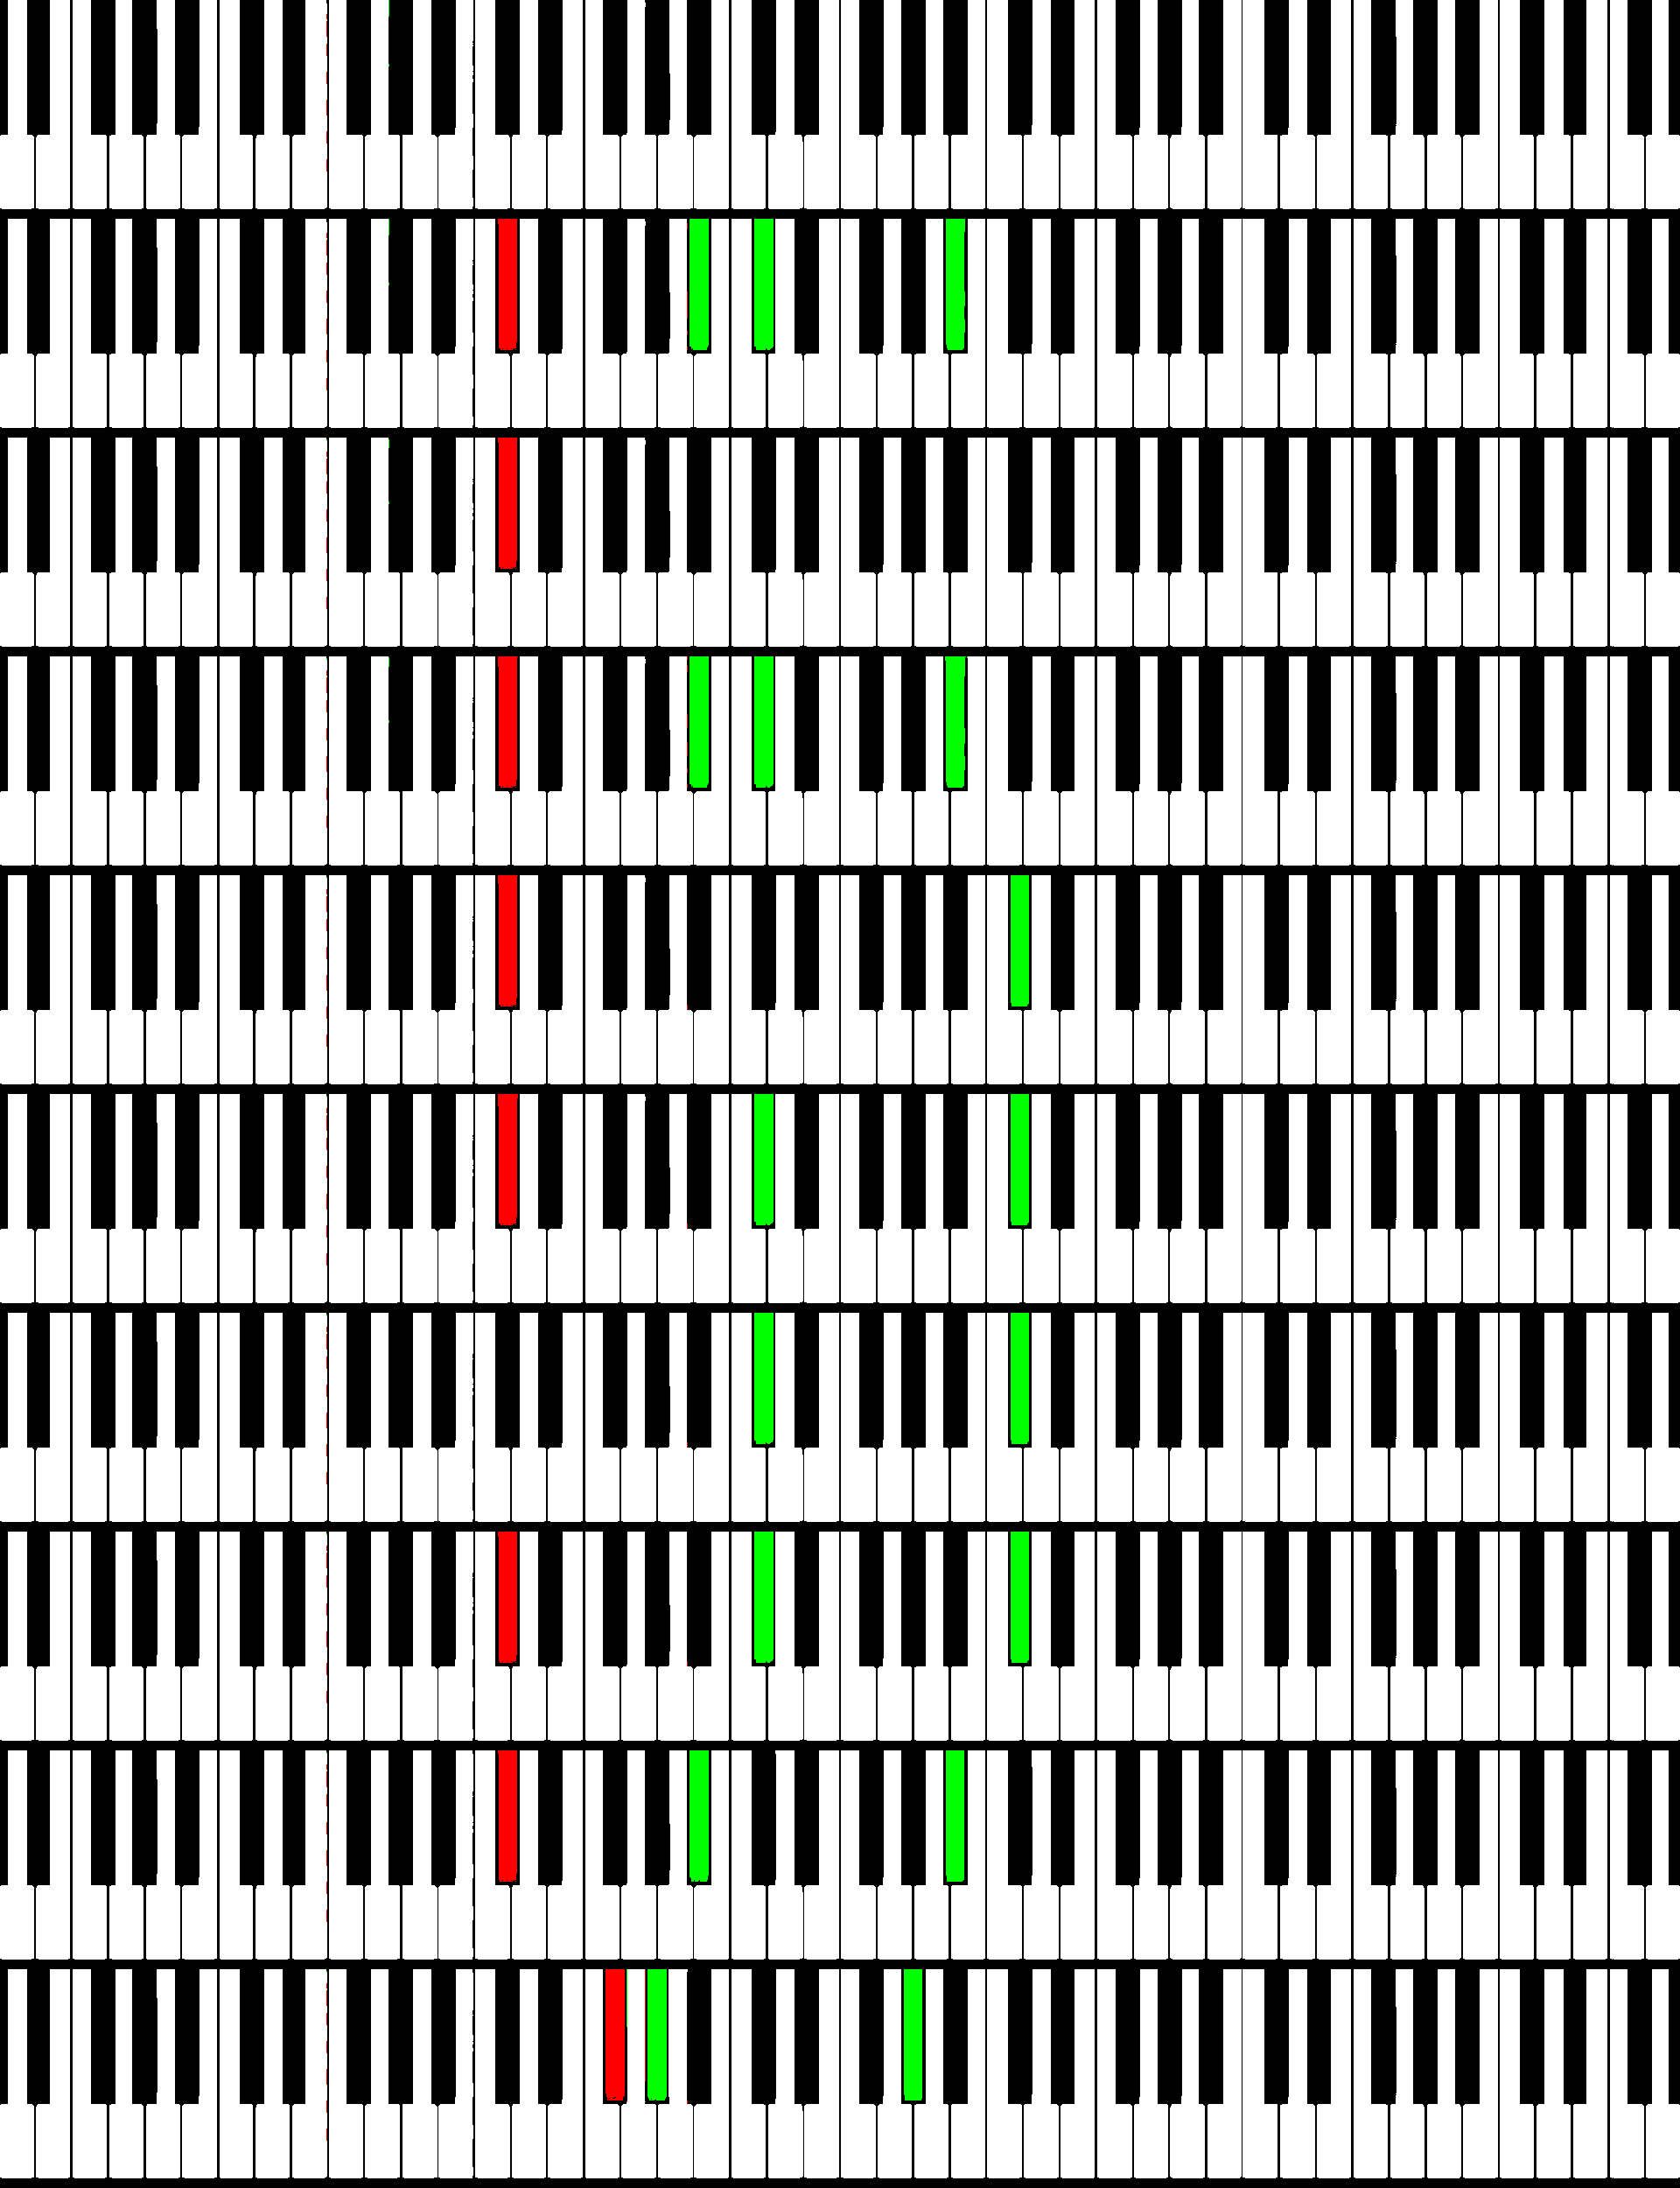

In [124]:
from src.image import frame_to_pil

print(music['left-hand'])
print(music['right-hand'])
print(times[50:60])
frame_to_pil(np.vstack(frames[50:60]))